In [4]:
from keras.models import Model, Sequential
from keras import layers
import numpy as np
from keras.applications import InceptionV3,InceptionResNetV2
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img
from keras import backend as K

import pickle
import h5py

In [5]:
word_embeddings = h5py.File('processed_data/meme_embeddings.hdf5')['meme_embeddings'][:]
with open('processed_data/meme_vocabulary.p', 'rb') as f:
    vocabulary = pickle.load(f)

assert(len(word_embeddings) == len(vocabulary)+1)
VOCAB_SIZE = len(vocabulary)+1

In [6]:
# Image embedding
img_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(216,216,3), pooling='avg')


In [7]:
# Meme label embedding
def embedding_avg(x):
    return K.mean(x, axis=1)

labels_input = layers.Input(shape=(None,))
glove_embedding = layers.Embedding(VOCAB_SIZE, 300, weights=[word_embeddings], mask_zero=True, input_length=25)
label_embedding = glove_embedding(labels_input)
label_avg_embedding = layers.Lambda(embedding_avg)(label_embedding)

In [8]:
# Embedding model

concat = layers.Concatenate()([img_model.output, label_avg_embedding])
embedding = layers.Dense(300)(concat)
rshp = layers.Reshape((1,300))(embedding)
lstm_layer = layers.LSTM(512, return_sequences=True, return_state=True)
_, lstm_initial_state1, lstm_initial_state2 = lstm_layer(rshp)


seq_input = layers.Input(shape=(None,))
x = glove_embedding(seq_input)
x, _, _ = lstm_layer(x, initial_state=[lstm_initial_state1, lstm_initial_state2])
x = layers.TimeDistributed(layers.Dense(VOCAB_SIZE, activation='softmax'))(x)

embedding_model = Model(inputs=[img_model.input, labels_input, seq_input], outputs=x)

embedding_model.compile('adam', 'categorical_crossentropy')


In [9]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 216, 216, 3)  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 107, 107, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 107, 107, 32) 96          conv2d_67[0][0]                  
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 107, 107, 32) 0           batch_normalization_67[0][0]     
__________________________________________________________________________________________________
conv2d_68 

In [10]:
X = h5py.File('processed_data/X.hdf5')
X1 = X['X_img']
X2 = X['X_label']
X3 = X['X_caption']
y = h5py.File('processed_data/y.hdf5')['y']

In [11]:
X1, X2, X3, y

(<HDF5 dataset "X_img": shape (27217, 216, 216, 3), type "<f4">,
 <HDF5 dataset "X_label": shape (27217, 25), type "<i4">,
 <HDF5 dataset "X_caption": shape (27217, 25), type "<i4">,
 <HDF5 dataset "y": shape (27217, 25, 9784), type "|b1">)

In [55]:
embedding_model.fit(x=[X1, X2, X3], y=y, batch_size=32, epochs=1, shuffle='batch')

Epoch 1/1
16704/27217 [=================>............] - ETA: 32:04 - loss: 2.9374

KeyboardInterrupt: 

# Inference

In [56]:
from PIL import Image
from pathlib import Path
import os

In [57]:
with open('processed_data/inference_meme_embeddings.p', 'rb') as f:
    img_label_embeddings = pickle.load(f)

inv_map = {v: k for k, v in vocabulary.items()}

def decode_softmax(predict):
    for seq in predict:
        l = []
        for logits in seq:
            idx = np.random.choice(VOCAB_SIZE, p=logits)
            if idx != 0:
                word = inv_map[idx]
                if word == '<end>':
                    break
                else:
                    l.append(word)
        print(' '.join(l))

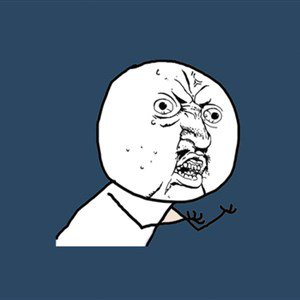

mean job <sep> i gets when would used i <sep> i hi should <sep> related if <sep> hide stop <sep> y one <sep> eat gone
bitch i'll bieber <sep> brace could not oh one oh sorry im play mom sorry line <sep> <sep> <sep> finally she gym <sep> yourself <sep>
should should i girl <sep> when bitch it's love <sep> <sep> i would simply mean bitch " <sep> <sep> <sep> doesn't i become when or
<sep> mom <sep> they until you're mom
she <sep> mean did finally i <sep> could <sep> <sep> don't i ? <sep> if <sep> yo too what doctor you mean don't <sep> mom


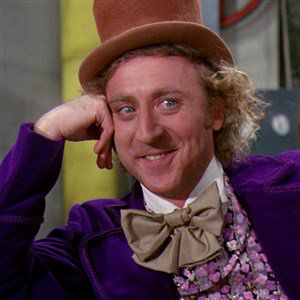

<sep> not could all yourself going <sep> i star <sep> <sep> " guy <sep>
<sep> <sep> simply oh play it's ... im <sep> so oh so or boyfriend <sep> why <sep> <sep> i bed i if she she "
when mean i bed <sep> kill oh i did <sep> tries <sep> who boobs doctor post asks mom gets <sep> gets <unk> mean i car
star <sep> <sep> 2 <sep> <sep> if would what looking hi i would she style better she research tired how what pee home it's mom
help i mom <sep> she <sep> <sep> telling virginity i so you're <sep> girl loses job baby bitch finally <sep> told she she <sep> girl


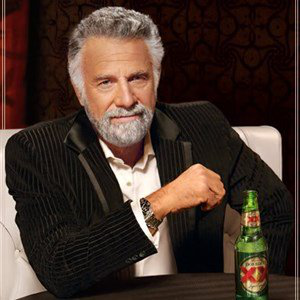

mom <sep> <sep> when become read <sep> <sep> <sep> doesn't not <sep> <sep> if fart <sep> to <sep> <sep> come oh <sep> <sep> <sep> could
oh <sep> what must <sep> gets do alone bieber <sep> goes boobs telling i didn't could <sep> if son <sep> <sep> tell one when <sep>
fart did stop <sep> luck loses if <sep> <sep> <sep> tried a <sep> what <sep> <sep> you're did <sep> if <sep> <sep> <sep> <sep> ?
<sep> oh i stop <sep> when eye they baby u clean i <sep> what meme " <sep> i one <sep> have / you're sorry <sep>
<sep> did <sep> brace if girl i when mean <sep> have ring could " she not <unk> could " it's telling <sep> <sep> <sep> stop


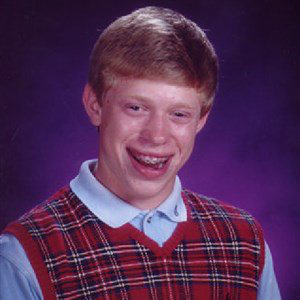

would 3 <sep> <sep> one one <sep> want it's wow if fart <sep> <sep> instagram did i i she oh oh for <sep> <sep> stop
gets it's <sep> you're eye told pregnant 2 <sep> play <sep> <sep> girl <sep> what doctor please asks did <sep> i what mean one would
i start
" i'm <sep> it's <sep> okay didn't <unk> she when and mean <sep> boobs gets i , <sep> <sep> <sep> she door an you've girl
2 she <sep> become told cook <sep> <sep> yo i mom get one play come gets i car mean <sep> when it's 3 what could


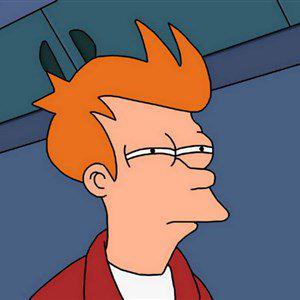

cut others <sep> teacher <sep> <unk> have should <sep>
if i oh says friend <sep> if <sep> does to
hand doctor / lost <sep> <sep> <sep> didn't <sep> <unk> you you're mean <sep> she <unk> <sep> <sep> <sep> if how not dress <sep> <sep>
it's you no <sep> <sep> one bad says did could i <sep> why but fat they i not gets <sep> <sep> hold <sep> girl i
<sep> <sep> gonna


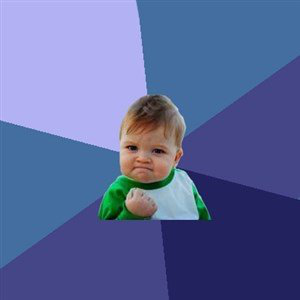

she <sep> you're teacher job when simply why i <sep> buys was 2 <sep> but oh " she if not mean mean didn't mom <sep>
<sep> did <sep> what " baby <sep> oh <sep> but quit finally <sep> <sep> job stop so better she i i did simply she <sep>
mean <sep> <sep> <sep> no telling work <sep> " read toilet <sep> <sep> who star <sep> gets <sep> <sep> <sep> gangnam told making oh <sep>
gets star would " join it's <sep> didn't guys eye so mom did <sep> might or if time poop <sep> <sep> " <sep> jail could
it's who hi job <sep> what if or did <sep> <sep> <sep> <sep> alone cause u better im <sep> car i i <sep> does


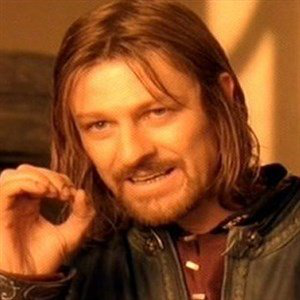

guy boobs <sep> told when <sep> profile <sep> i she if i
<sep> wait ? does movie baby posts <sep> guys gets had if <sep> " it's i have <sep> girl tries post finally mean pee do
<sep> <sep> <sep> <sep> <sep> mom <sep> if pee <sep>
hey kill hell <sep> <sep> <sep> <sep> did <sep> <sep> try okay <sep> <sep> ... when mean head not i it's weight ? not <sep>
could she or !? <sep> door <sep> doesn't is gonna she doesn't <sep> stop fuck google but pee what mean <sep> she i <sep> stop


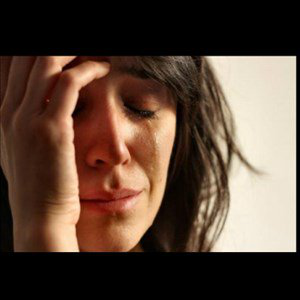

tits i when ever " could i <sep> <sep> they looking i <sep> <sep> y okay mom <sep> <sep> <sep> could gonna mom so <sep>
<sep> mom i " <sep> told <sep> they she <sep> or i <sep> but supposed ... google <sep> awkward ! i it's bieber ' asks
<sep> i <sep> <sep> one did
<sep> girl <sep> pee mom <sep> <sep> she too does read <sep> hi <sep> what
<sep> why mean she when someone one <sep> she <sep> told when <sep> <sep> " oh yourself to mom <sep> baby <sep> mean lost car


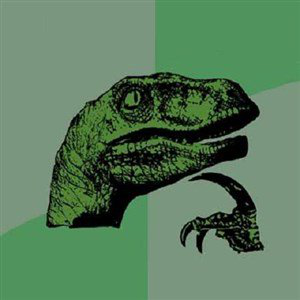

<sep> when die <sep> pee <sep> <sep> did i oh she kill buys walmart her sorry <sep> <sep> yourself it's
could <sep> not when gets have fun <sep> <sep> it's job what steve gets <sep> oh it's " <sep> hello sure stop " if "
or <sep> accepted she " i stop <sep> could when eye <sep> <sep> tv gets okay she " tries what ! and i when baby

<sep> i did comment should better if pee stop <sep> <sep> <sep> oh <sep> <unk> if mom do i oh im could she <sep> i


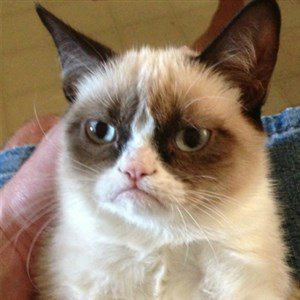

could sure pee mean have when <sep> or it's 2 they <sep> <sep> one ? <sep> <sep> your she so <sep> car does - <sep>
store <sep> i " coming didn't kill try <sep> does oh awkward when <sep> <sep> <sep> does <sep> gets become <sep> <sep> goes fart if
guys oh phd <sep> ?
tell and <sep> <sep> <sep> so did she tries <sep> could one . doesn't going baby do at mom <sep> i she i <sep> "
what if one would <sep> suicide asks <sep> she i have if <sep> <sep> gonna <sep> girl <sep> probably <sep> <sep> <sep> it's <sep> doctor


In [60]:
p = Path('memes')
images = list(p.glob('*.png'))
images.sort(key=os.path.getmtime)
meme_files = list(map(lambda x: x.stem, images))[:10]


for i, meme in enumerate(meme_files):
    X_test_img = np.tile(img_label_embeddings[meme][0], (5, 1, 1, 1))
    X_test_label = np.tile(img_label_embeddings[meme][1], (5, 1))
    X_test_caption = np.zeros((5, 25))
    display(Image.open(images[i]))
    preds = embedding_model.predict([X_test_img, X_test_label, X_test_caption])
    decode_softmax(preds)